In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mars-for-students/mars_for_students.npz


In [2]:
from datetime import datetime

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


In [3]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [4]:
data = np.load("/kaggle/input/mars-for-students/mars_for_students.npz")

training_set = data["training_set"]
X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train_val.shape}")
print(f"Training y shape: {y_train_val.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [5]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 300

In [6]:
# Add color channel and rescale pixels between 0 and 1
X_train_val = X_train_val[..., np.newaxis] / 255.0
y_train_val = y_train_val[..., np.newaxis]
X_test = X_test[..., np.newaxis] / 255.0

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed )


input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [7]:
print(f"Label shape: {y_train.shape[1:]}")


Label shape: (64, 128, 1)


In [8]:
label_name = {0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
    }

In [9]:
'''geometrical transformations must be specified on both images and labels,
thus it is much easier to apply them separately and them feed the already
augmented versions.
ALSO LABELS MUST BE AUGMENTED!'''

@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [10]:
def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE) #speedup, prec arica le immagine

    return dataset

In [11]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)


print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float64'>


Visualizing examples from the training set:


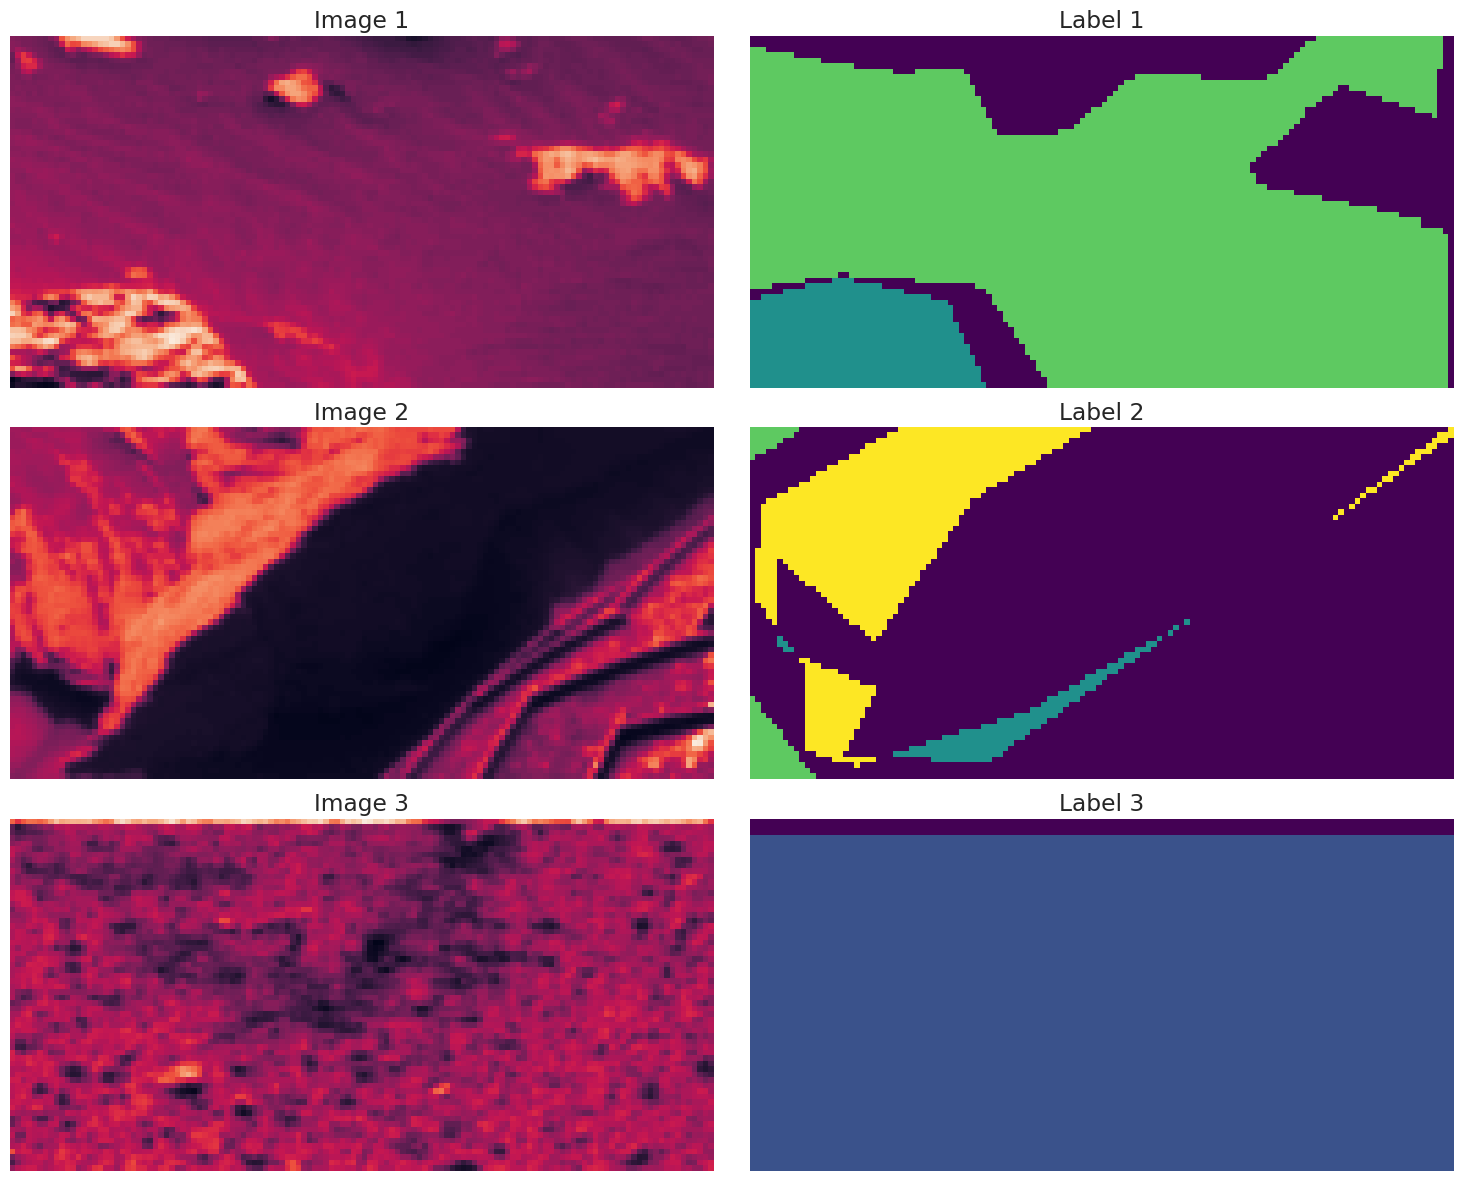

In [12]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

In [13]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [14]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckconv1   │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckbn1     │ (None, 16, 32,  │       512 │ bottleneckcon… │   Y 

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

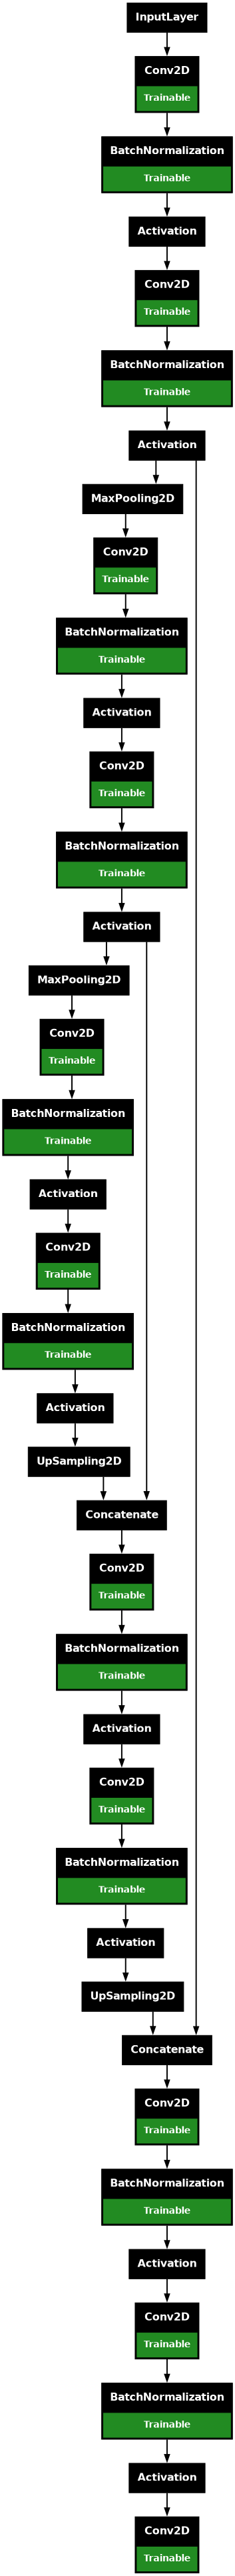

In [15]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [16]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels  ->IMPORTANT FOR HOMEWORK
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val,  frequency=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.num_classes = 5
        self.frequency = frequency
        self.print= False

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            if self.print:
                print("X_val shape:", self.X_val.shape)
                print("y_val shape:", self.y_val.shape)

            image = self.X_val
            label = self.y_val
            if self.print:
                print("Images shape:", image.shape)
                print("Labels shape:", label.shape)
            
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0) #300x64x128x5 [0,1]
            y_pred = tf.math.argmax(pred, axis=-1) #300x64x128 [0,4]
            y_pred = y_pred.numpy() 

            if self.print:
                print("pred shape:", pred.shape)
                print("y_pred shape:", y_pred.shape)


            
            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [17]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
) #accuracy is pixelwise, not very relevant but still useful for some small objects such as cars. the second custom measure is much better
print("Model compiled!")

Compiling model...
Model compiled!


In [18]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(tf.convert_to_tensor(X_val[0]), tf.convert_to_tensor(y_val[0]),5)

Epoch 1/1000


I0000 00:00:1733217410.926853      69 service.cc:145] XLA service 0x7b2e04044ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733217410.926924      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733217410.926932      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733217416.481864      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


 1/37 ━━━━━━━━━━━━━━━━━━━━ 17:24 29s/step - accuracy: 0.1732 - loss: 1.9475 - mean_iou: 0.0758

I0000 00:00:1733217433.387829      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3557 - loss: 1.5230 - mean_iou: 0.1567

W0000 00:00:1733217438.728163      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.3575 - loss: 1.5192 - mean_iou: 0.1577

W0000 00:00:1733217451.644921      68 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733217454.749624      70 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


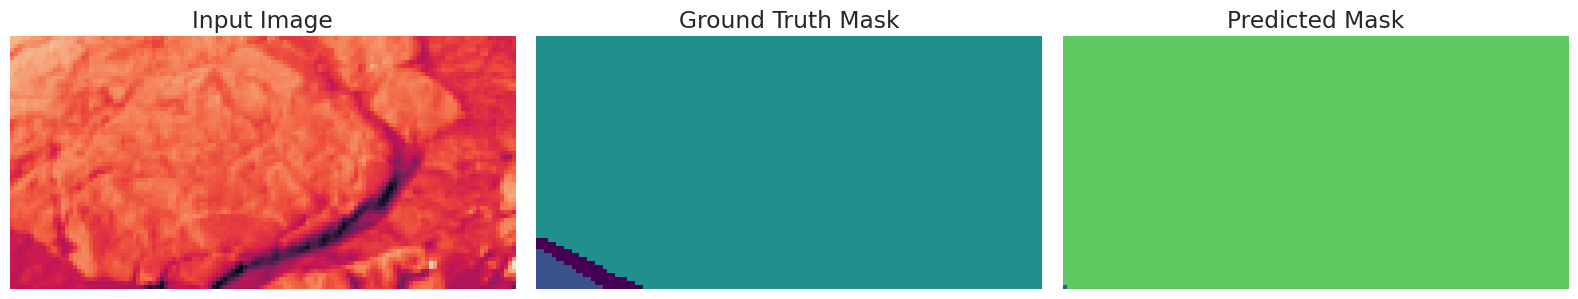

37/37 ━━━━━━━━━━━━━━━━━━━━ 53s 659ms/step - accuracy: 0.3593 - loss: 1.5157 - mean_iou: 0.1586 - val_accuracy: 0.1830 - val_loss: 2.4245 - val_mean_iou: 0.0613
Epoch 2/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.5386 - loss: 1.1658 - mean_iou: 0.2773 - val_accuracy: 0.1830 - val_loss: 3.2876 - val_mean_iou: 0.0613
Epoch 3/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.5804 - loss: 1.0589 - mean_iou: 0.3005 - val_accuracy: 0.1830 - val_loss: 4.0067 - val_mean_iou: 0.0613
Epoch 4/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.6144 - loss: 0.9824 - mean_iou: 0.3328 - val_accuracy: 0.1830 - val_loss: 4.4692 - val_mean_iou: 0.0490
Epoch 5/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.6192 - loss: 0.9576 - mean_iou: 0.3350 - val_accuracy: 0.1830 - val_loss: 5.9763 - val_mean_iou: 0.0613
Epoch 6/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6363 - loss: 0.9193 - mean_iou: 0.3515

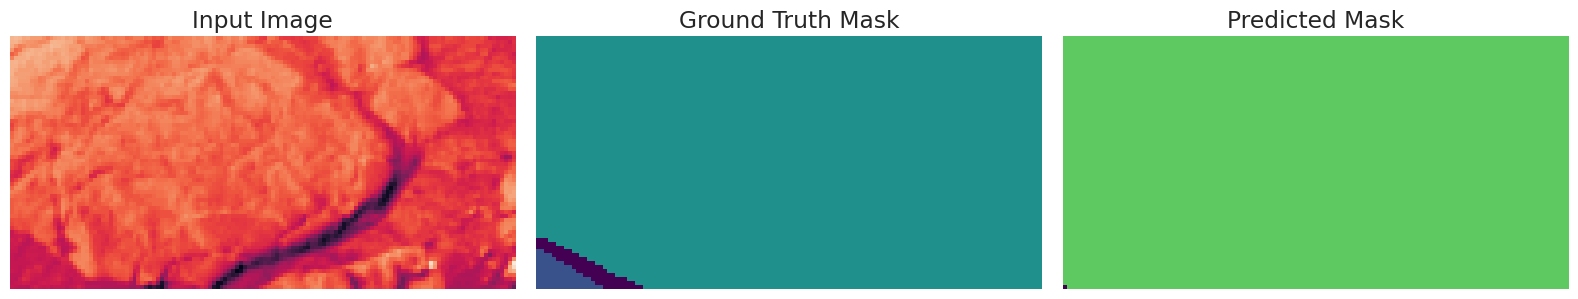

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.6371 - loss: 0.9178 - mean_iou: 0.3523 - val_accuracy: 0.1830 - val_loss: 4.8135 - val_mean_iou: 0.0490
Epoch 7/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.6415 - loss: 0.9103 - mean_iou: 0.3633 - val_accuracy: 0.1830 - val_loss: 4.4290 - val_mean_iou: 0.0490
Epoch 8/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6494 - loss: 0.8931 - mean_iou: 0.3692 - val_accuracy: 0.1831 - val_loss: 4.8039 - val_mean_iou: 0.0491
Epoch 9/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.6617 - loss: 0.8607 - mean_iou: 0.3797 - val_accuracy: 0.1826 - val_loss: 3.6721 - val_mean_iou: 0.0491
Epoch 10/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.6753 - loss: 0.8261 - mean_iou: 0.3851 - val_accuracy: 0.1830 - val_loss: 4.1417 - val_mean_iou: 0.0491
Epoch 11/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6844 - loss: 0.8106 - mean_iou: 0.3927

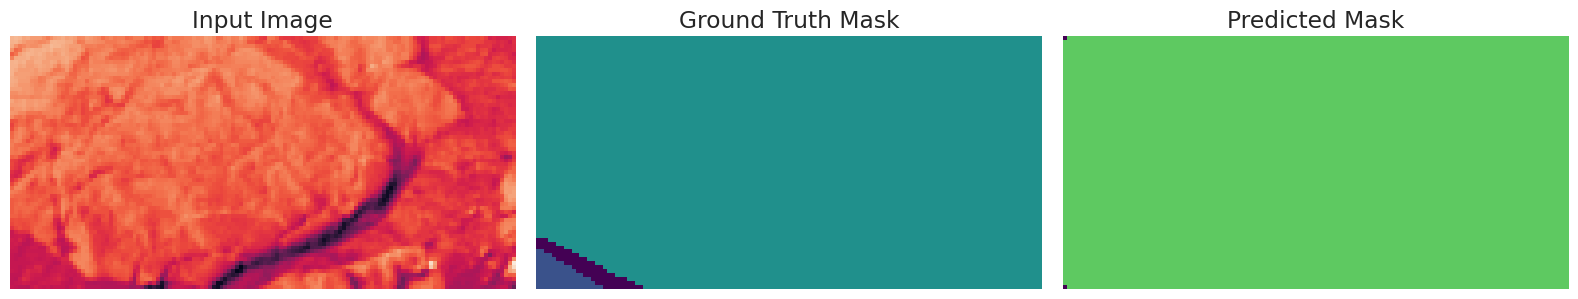

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.6845 - loss: 0.8102 - mean_iou: 0.3929 - val_accuracy: 0.1850 - val_loss: 3.9626 - val_mean_iou: 0.0499
Epoch 12/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.6947 - loss: 0.7964 - mean_iou: 0.4022 - val_accuracy: 0.2051 - val_loss: 3.2923 - val_mean_iou: 0.0626
Epoch 13/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.6879 - loss: 0.8046 - mean_iou: 0.3985 - val_accuracy: 0.2115 - val_loss: 2.9538 - val_mean_iou: 0.0625
Epoch 14/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.6694 - loss: 0.8477 - mean_iou: 0.3830 - val_accuracy: 0.2854 - val_loss: 2.5534 - val_mean_iou: 0.1060
Epoch 15/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.6955 - loss: 0.7770 - mean_iou: 0.4067 - val_accuracy: 0.3976 - val_loss: 1.7345 - val_mean_iou: 0.1854
Epoch 16/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7019 - loss: 0.7663 - mean_iou: 0.4097

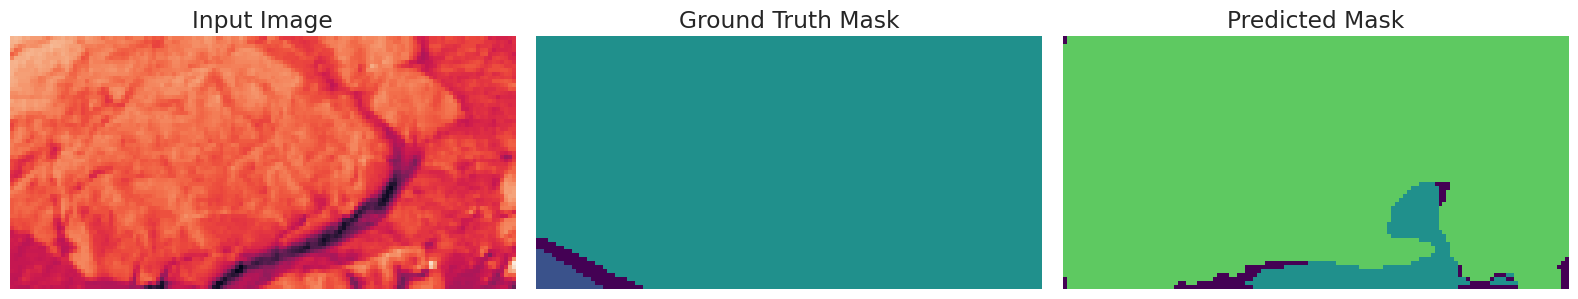

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.7021 - loss: 0.7656 - mean_iou: 0.4099 - val_accuracy: 0.3398 - val_loss: 2.1186 - val_mean_iou: 0.1390
Epoch 17/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.6993 - loss: 0.7736 - mean_iou: 0.4070 - val_accuracy: 0.3996 - val_loss: 1.8824 - val_mean_iou: 0.1579
Epoch 18/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7028 - loss: 0.7699 - mean_iou: 0.4082 - val_accuracy: 0.4031 - val_loss: 2.0516 - val_mean_iou: 0.1520
Epoch 19/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7099 - loss: 0.7456 - mean_iou: 0.4196 - val_accuracy: 0.4816 - val_loss: 1.5036 - val_mean_iou: 0.2132
Epoch 20/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7018 - loss: 0.7650 - mean_iou: 0.4166 - val_accuracy: 0.6543 - val_loss: 0.8952 - val_mean_iou: 0.3454
Epoch 21/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7192 - loss: 0.7265 - mean_iou: 0.4260

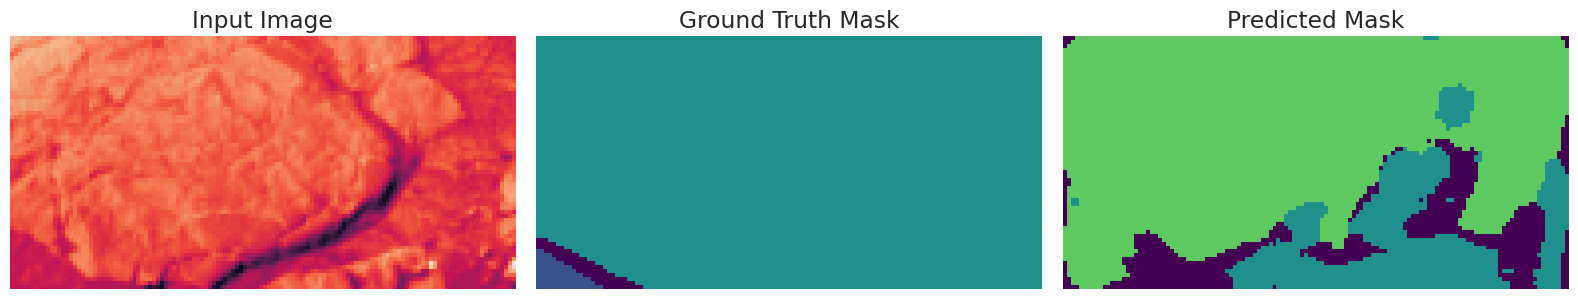

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.7193 - loss: 0.7265 - mean_iou: 0.4260 - val_accuracy: 0.4355 - val_loss: 1.6872 - val_mean_iou: 0.1642
Epoch 22/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7080 - loss: 0.7509 - mean_iou: 0.4152 - val_accuracy: 0.4298 - val_loss: 1.6046 - val_mean_iou: 0.1385
Epoch 23/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7265 - loss: 0.7149 - mean_iou: 0.4301 - val_accuracy: 0.3651 - val_loss: 2.0848 - val_mean_iou: 0.0832
Epoch 24/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7375 - loss: 0.6909 - mean_iou: 0.4446 - val_accuracy: 0.4718 - val_loss: 1.5246 - val_mean_iou: 0.1938
Epoch 25/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.6851 - loss: 0.8101 - mean_iou: 0.3909 - val_accuracy: 0.4737 - val_loss: 1.4962 - val_mean_iou: 0.1898
Epoch 26/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7309 - loss: 0.7057 - mean_iou: 0.4378

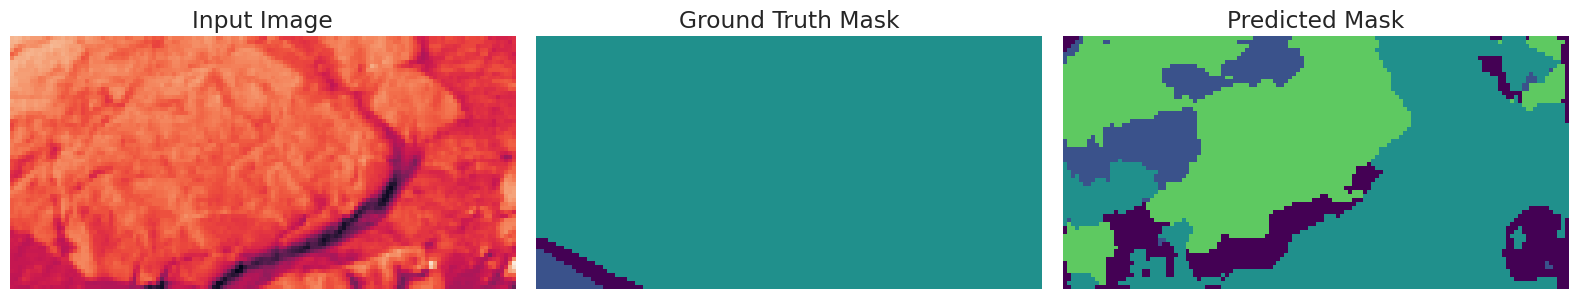

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.7310 - loss: 0.7052 - mean_iou: 0.4378 - val_accuracy: 0.6811 - val_loss: 0.8378 - val_mean_iou: 0.3917
Epoch 27/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7407 - loss: 0.6763 - mean_iou: 0.4480 - val_accuracy: 0.5489 - val_loss: 1.1620 - val_mean_iou: 0.2937
Epoch 28/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.7335 - loss: 0.6901 - mean_iou: 0.4396 - val_accuracy: 0.7087 - val_loss: 0.7494 - val_mean_iou: 0.4249
Epoch 29/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7415 - loss: 0.6718 - mean_iou: 0.4481 - val_accuracy: 0.4918 - val_loss: 1.3471 - val_mean_iou: 0.2226
Epoch 30/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7452 - loss: 0.6630 - mean_iou: 0.4481 - val_accuracy: 0.5333 - val_loss: 1.2329 - val_mean_iou: 0.2899
Epoch 31/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7401 - loss: 0.6745 - mean_iou: 0.4456

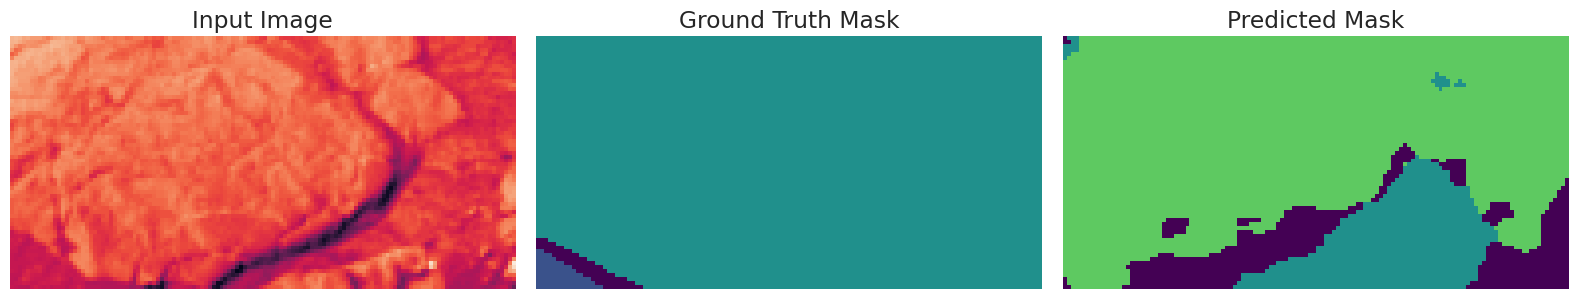

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.7404 - loss: 0.6737 - mean_iou: 0.4457 - val_accuracy: 0.6368 - val_loss: 0.9692 - val_mean_iou: 0.3244
Epoch 32/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7379 - loss: 0.6772 - mean_iou: 0.4403 - val_accuracy: 0.6850 - val_loss: 0.8131 - val_mean_iou: 0.3925
Epoch 33/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7531 - loss: 0.6417 - mean_iou: 0.4551 - val_accuracy: 0.6952 - val_loss: 0.7930 - val_mean_iou: 0.4063
Epoch 34/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7441 - loss: 0.6579 - mean_iou: 0.4473 - val_accuracy: 0.6084 - val_loss: 0.9850 - val_mean_iou: 0.3285
Epoch 35/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7396 - loss: 0.6720 - mean_iou: 0.4440 - val_accuracy: 0.4403 - val_loss: 1.5384 - val_mean_iou: 0.1750
Epoch 36/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7517 - loss: 0.6450 - mean_iou: 0.4585

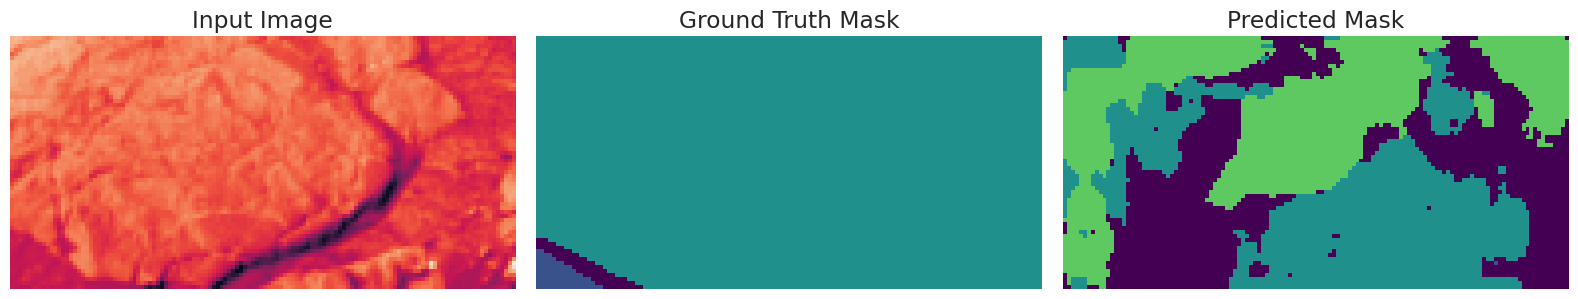

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.7521 - loss: 0.6440 - mean_iou: 0.4586 - val_accuracy: 0.5753 - val_loss: 0.9901 - val_mean_iou: 0.2690
Epoch 37/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7564 - loss: 0.6304 - mean_iou: 0.4580 - val_accuracy: 0.6995 - val_loss: 0.8108 - val_mean_iou: 0.4184
Epoch 38/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7663 - loss: 0.6099 - mean_iou: 0.4701 - val_accuracy: 0.6513 - val_loss: 0.9474 - val_mean_iou: 0.3738
Epoch 39/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7547 - loss: 0.6413 - mean_iou: 0.4604 - val_accuracy: 0.4688 - val_loss: 1.5655 - val_mean_iou: 0.1978
Epoch 40/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7638 - loss: 0.6163 - mean_iou: 0.4654 - val_accuracy: 0.6863 - val_loss: 0.8427 - val_mean_iou: 0.3862
Epoch 41/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7663 - loss: 0.6030 - mean_iou: 0.4706

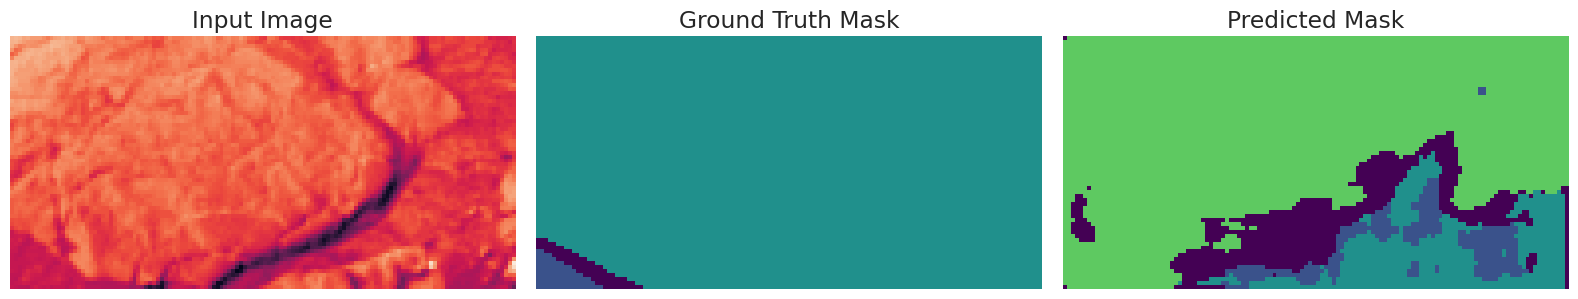

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.7665 - loss: 0.6026 - mean_iou: 0.4706 - val_accuracy: 0.4939 - val_loss: 1.3757 - val_mean_iou: 0.2194
Epoch 42/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7768 - loss: 0.5771 - mean_iou: 0.4809 - val_accuracy: 0.3398 - val_loss: 2.3091 - val_mean_iou: 0.0840
Epoch 43/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7637 - loss: 0.6137 - mean_iou: 0.4607 - val_accuracy: 0.3347 - val_loss: 2.6401 - val_mean_iou: 0.0710
Epoch 44/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7666 - loss: 0.6045 - mean_iou: 0.4696 - val_accuracy: 0.3396 - val_loss: 2.4354 - val_mean_iou: 0.0790
Epoch 45/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7747 - loss: 0.5843 - mean_iou: 0.4720 - val_accuracy: 0.3577 - val_loss: 2.1833 - val_mean_iou: 0.1107
Epoch 46/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7824 - loss: 0.5662 - mean_iou: 0.4771

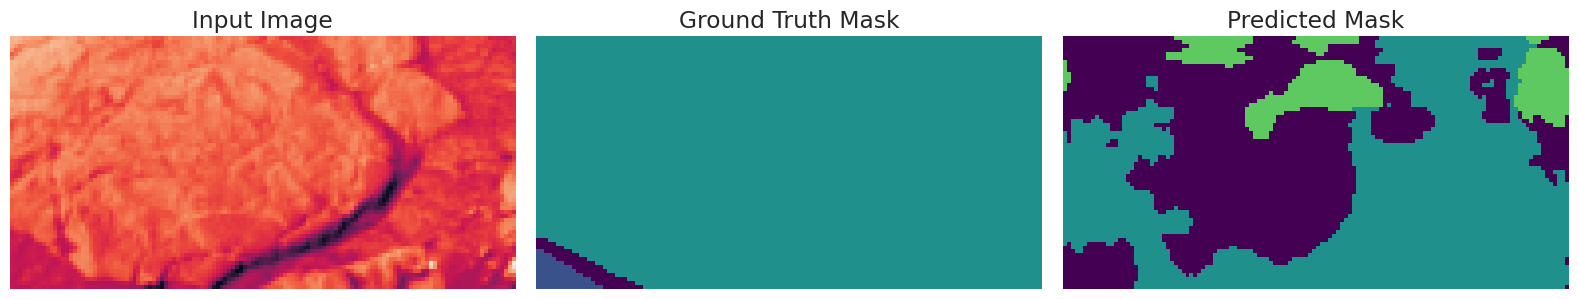

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.7823 - loss: 0.5663 - mean_iou: 0.4771 - val_accuracy: 0.4097 - val_loss: 1.8916 - val_mean_iou: 0.1229
Epoch 47/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7770 - loss: 0.5800 - mean_iou: 0.4710 - val_accuracy: 0.6316 - val_loss: 0.9706 - val_mean_iou: 0.3306
Epoch 48/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7777 - loss: 0.5828 - mean_iou: 0.4757 - val_accuracy: 0.4720 - val_loss: 1.4275 - val_mean_iou: 0.1906
Epoch 49/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7845 - loss: 0.5586 - mean_iou: 0.4850 - val_accuracy: 0.5858 - val_loss: 1.0728 - val_mean_iou: 0.3079
Epoch 50/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7754 - loss: 0.5788 - mean_iou: 0.4713 - val_accuracy: 0.5779 - val_loss: 1.0743 - val_mean_iou: 0.2909
Epoch 51/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7818 - loss: 0.5688 - mean_iou: 0.4793

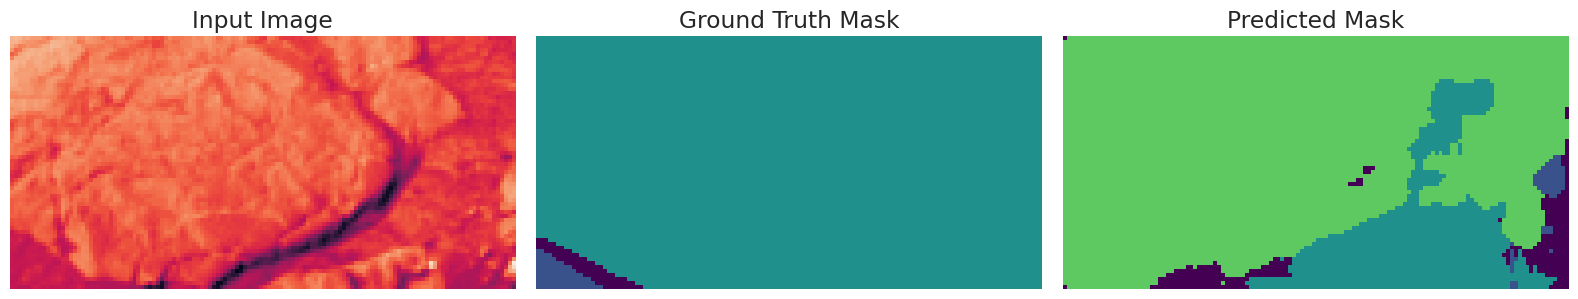

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.7816 - loss: 0.5691 - mean_iou: 0.4790 - val_accuracy: 0.6383 - val_loss: 0.9274 - val_mean_iou: 0.3411
Epoch 52/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7789 - loss: 0.5657 - mean_iou: 0.4794 - val_accuracy: 0.6361 - val_loss: 0.9452 - val_mean_iou: 0.3319
Epoch 53/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7968 - loss: 0.5320 - mean_iou: 0.4919 - val_accuracy: 0.6276 - val_loss: 1.0675 - val_mean_iou: 0.3397
Epoch 54/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7703 - loss: 0.6012 - mean_iou: 0.4653 - val_accuracy: 0.6645 - val_loss: 0.9380 - val_mean_iou: 0.3597
Epoch 55/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7980 - loss: 0.5234 - mean_iou: 0.4900 - val_accuracy: 0.7102 - val_loss: 0.7483 - val_mean_iou: 0.4310
Epoch 56/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8022 - loss: 0.5123 - mean_iou: 0.4945

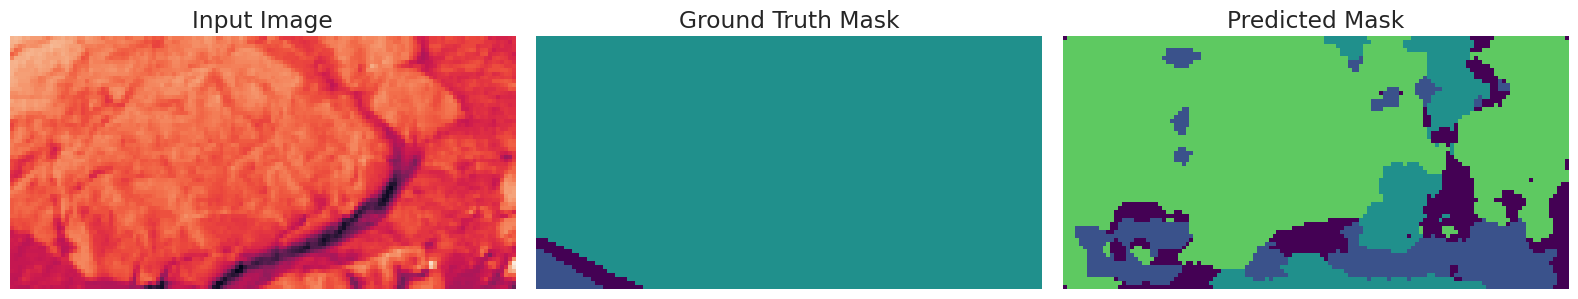

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.8021 - loss: 0.5127 - mean_iou: 0.4943 - val_accuracy: 0.6758 - val_loss: 0.8130 - val_mean_iou: 0.3670
Epoch 57/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.7902 - loss: 0.5434 - mean_iou: 0.4844 - val_accuracy: 0.7194 - val_loss: 0.7570 - val_mean_iou: 0.4215
Epoch 58/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8033 - loss: 0.5179 - mean_iou: 0.4946 - val_accuracy: 0.6617 - val_loss: 0.8649 - val_mean_iou: 0.3460
Epoch 59/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8048 - loss: 0.5070 - mean_iou: 0.4936 - val_accuracy: 0.4165 - val_loss: 1.5996 - val_mean_iou: 0.1531
Epoch 60/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.8122 - loss: 0.4859 - mean_iou: 0.5042 - val_accuracy: 0.6813 - val_loss: 0.8624 - val_mean_iou: 0.3799
Epoch 61/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8093 - loss: 0.4967 - mean_iou: 0.4971

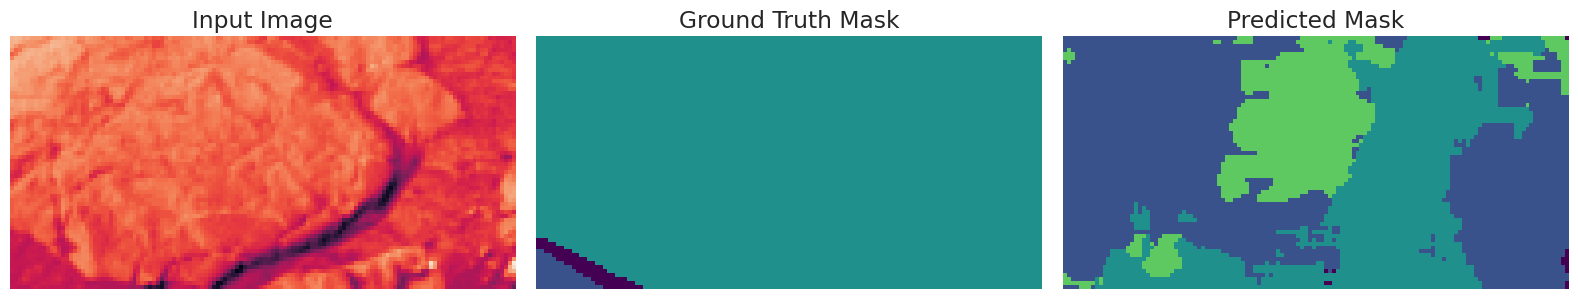

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.8096 - loss: 0.4959 - mean_iou: 0.4973 - val_accuracy: 0.6813 - val_loss: 0.8157 - val_mean_iou: 0.3868
Epoch 62/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8107 - loss: 0.4896 - mean_iou: 0.5030 - val_accuracy: 0.5993 - val_loss: 1.0793 - val_mean_iou: 0.2749
Epoch 63/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8075 - loss: 0.4968 - mean_iou: 0.4967 - val_accuracy: 0.5876 - val_loss: 1.0411 - val_mean_iou: 0.2787
Epoch 64/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8106 - loss: 0.4926 - mean_iou: 0.5003 - val_accuracy: 0.5839 - val_loss: 1.4865 - val_mean_iou: 0.3200
Epoch 65/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8122 - loss: 0.4847 - mean_iou: 0.5006 - val_accuracy: 0.5094 - val_loss: 1.7211 - val_mean_iou: 0.2579
Epoch 66/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8178 - loss: 0.4745 - mean_iou: 0.5076

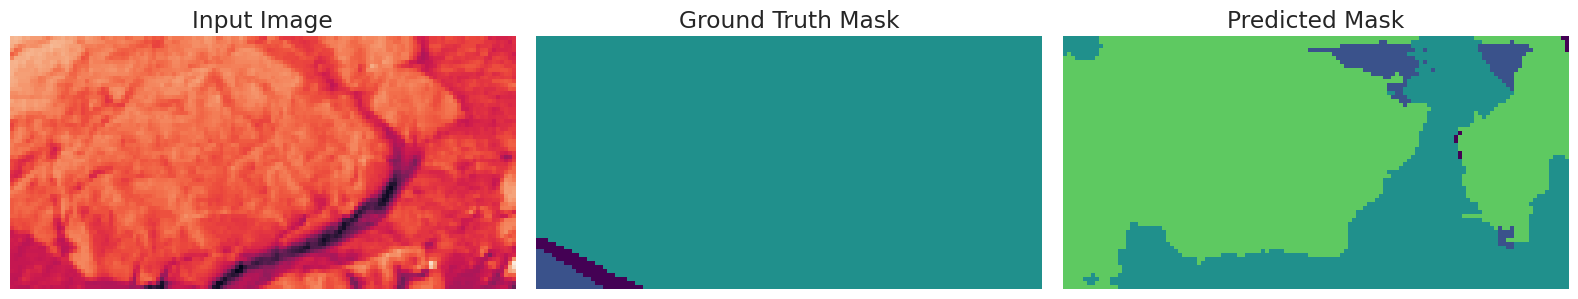

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.8181 - loss: 0.4740 - mean_iou: 0.5075 - val_accuracy: 0.4696 - val_loss: 1.6732 - val_mean_iou: 0.2307
Epoch 67/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8085 - loss: 0.4875 - mean_iou: 0.5043 - val_accuracy: 0.4474 - val_loss: 2.0839 - val_mean_iou: 0.2026
Epoch 68/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8263 - loss: 0.4511 - mean_iou: 0.5142 - val_accuracy: 0.6216 - val_loss: 0.9361 - val_mean_iou: 0.3027
Epoch 69/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8141 - loss: 0.4781 - mean_iou: 0.5007 - val_accuracy: 0.5895 - val_loss: 1.0383 - val_mean_iou: 0.2874
Epoch 70/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7962 - loss: 0.5309 - mean_iou: 0.4832 - val_accuracy: 0.5759 - val_loss: 1.1887 - val_mean_iou: 0.2960
Epoch 71/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8121 - loss: 0.4841 - mean_iou: 0.4996

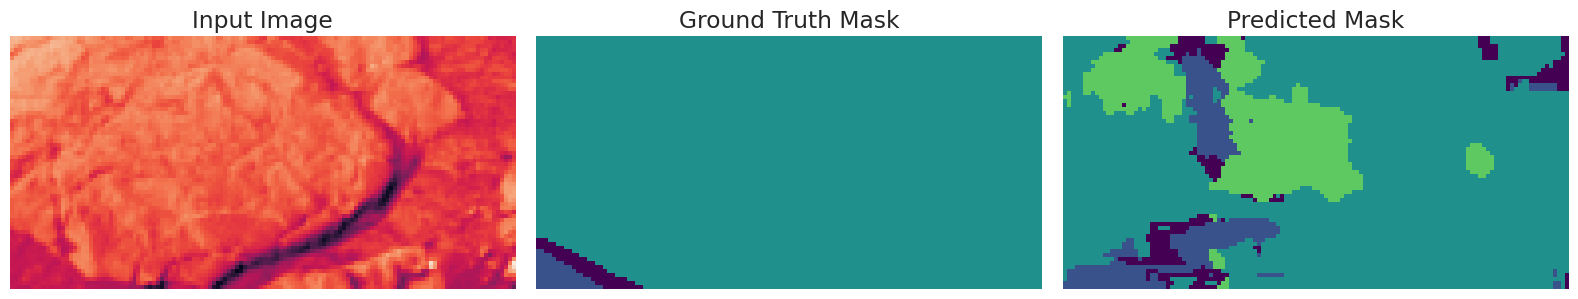

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.8125 - loss: 0.4830 - mean_iou: 0.5001 - val_accuracy: 0.7359 - val_loss: 0.6943 - val_mean_iou: 0.4483
Epoch 72/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8237 - loss: 0.4569 - mean_iou: 0.5104 - val_accuracy: 0.6106 - val_loss: 1.0638 - val_mean_iou: 0.3266
Epoch 73/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8304 - loss: 0.4402 - mean_iou: 0.5158 - val_accuracy: 0.6232 - val_loss: 0.9365 - val_mean_iou: 0.3574
Epoch 74/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8278 - loss: 0.4492 - mean_iou: 0.5165 - val_accuracy: 0.6822 - val_loss: 0.8145 - val_mean_iou: 0.3850
Epoch 75/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8435 - loss: 0.4111 - mean_iou: 0.5246 - val_accuracy: 0.5943 - val_loss: 1.0441 - val_mean_iou: 0.3077
Epoch 76/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8350 - loss: 0.4273 - mean_iou: 0.5206

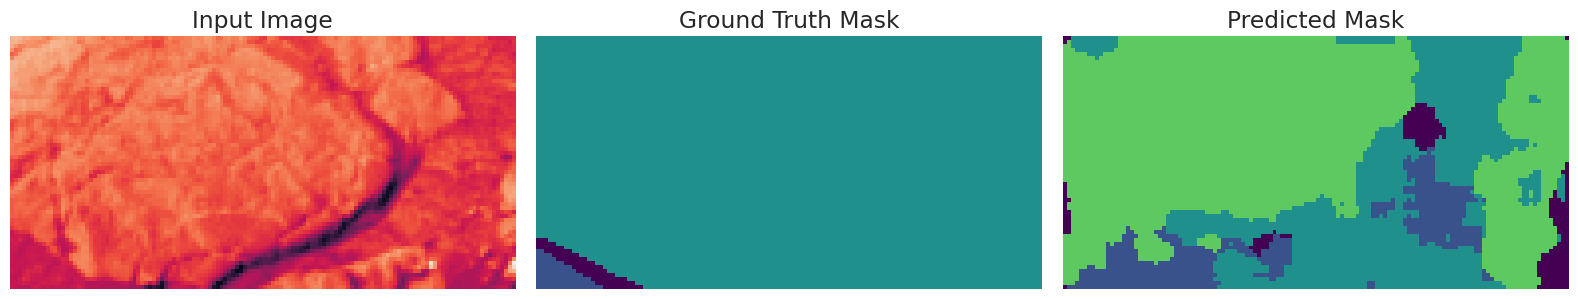

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.8352 - loss: 0.4268 - mean_iou: 0.5209 - val_accuracy: 0.6335 - val_loss: 1.0756 - val_mean_iou: 0.3511
Epoch 77/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8305 - loss: 0.4353 - mean_iou: 0.5317 - val_accuracy: 0.7048 - val_loss: 0.8257 - val_mean_iou: 0.4344
Epoch 78/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8369 - loss: 0.4221 - mean_iou: 0.5204 - val_accuracy: 0.7058 - val_loss: 0.7388 - val_mean_iou: 0.3954
Epoch 79/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8491 - loss: 0.3943 - mean_iou: 0.5355 - val_accuracy: 0.7048 - val_loss: 0.7666 - val_mean_iou: 0.4525
Epoch 80/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8405 - loss: 0.4084 - mean_iou: 0.5329 - val_accuracy: 0.6687 - val_loss: 0.8011 - val_mean_iou: 0.3945
Epoch 81/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8563 - loss: 0.3742 - mean_iou: 0.5524

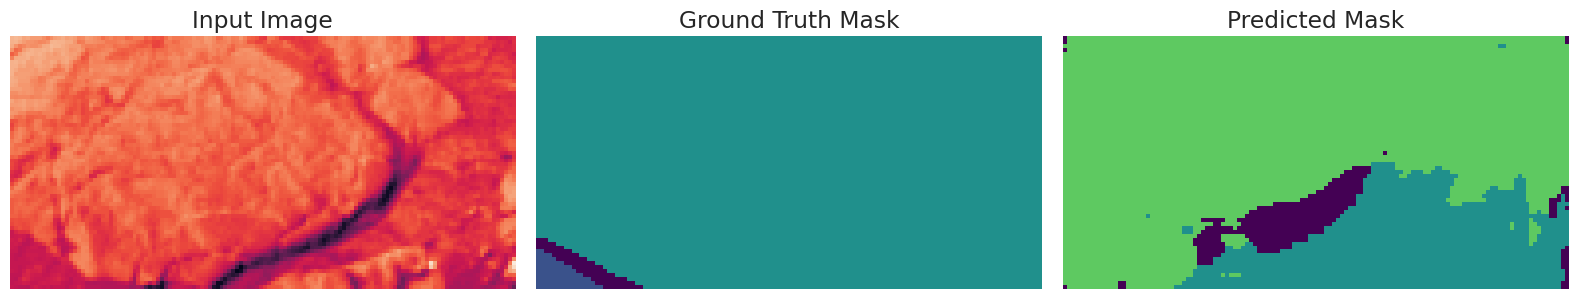

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.8564 - loss: 0.3739 - mean_iou: 0.5526 - val_accuracy: 0.4656 - val_loss: 1.6001 - val_mean_iou: 0.2017
Epoch 82/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.8633 - loss: 0.3602 - mean_iou: 0.5623 - val_accuracy: 0.7495 - val_loss: 0.6690 - val_mean_iou: 0.4809
Epoch 83/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8515 - loss: 0.3876 - mean_iou: 0.5500 - val_accuracy: 0.6526 - val_loss: 1.0723 - val_mean_iou: 0.3634
Epoch 84/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8596 - loss: 0.3674 - mean_iou: 0.5422 - val_accuracy: 0.7430 - val_loss: 0.7230 - val_mean_iou: 0.4553
Epoch 85/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8494 - loss: 0.3925 - mean_iou: 0.5494 - val_accuracy: 0.6918 - val_loss: 0.8208 - val_mean_iou: 0.3902
Epoch 86/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8662 - loss: 0.3505 - mean_iou: 0.5662

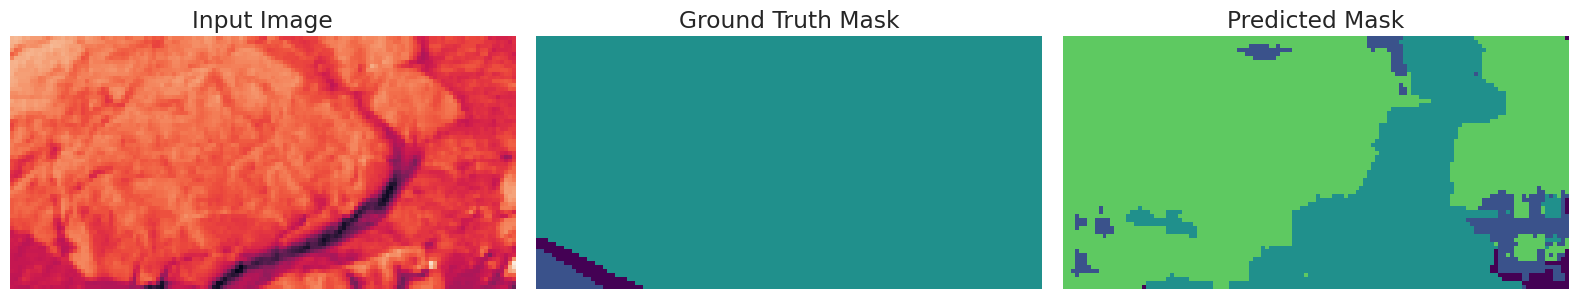

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.8664 - loss: 0.3502 - mean_iou: 0.5662 - val_accuracy: 0.6427 - val_loss: 1.0043 - val_mean_iou: 0.3469
Epoch 87/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8722 - loss: 0.3377 - mean_iou: 0.5609 - val_accuracy: 0.7008 - val_loss: 0.7566 - val_mean_iou: 0.4106
Epoch 88/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8609 - loss: 0.3644 - mean_iou: 0.5528 - val_accuracy: 0.5993 - val_loss: 1.2763 - val_mean_iou: 0.3540
Epoch 89/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8519 - loss: 0.3854 - mean_iou: 0.5548 - val_accuracy: 0.5987 - val_loss: 1.1197 - val_mean_iou: 0.2953
Epoch 90/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8575 - loss: 0.3701 - mean_iou: 0.5454 - val_accuracy: 0.6278 - val_loss: 1.2112 - val_mean_iou: 0.3479
Epoch 91/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8784 - loss: 0.3205 - mean_iou: 0.5736

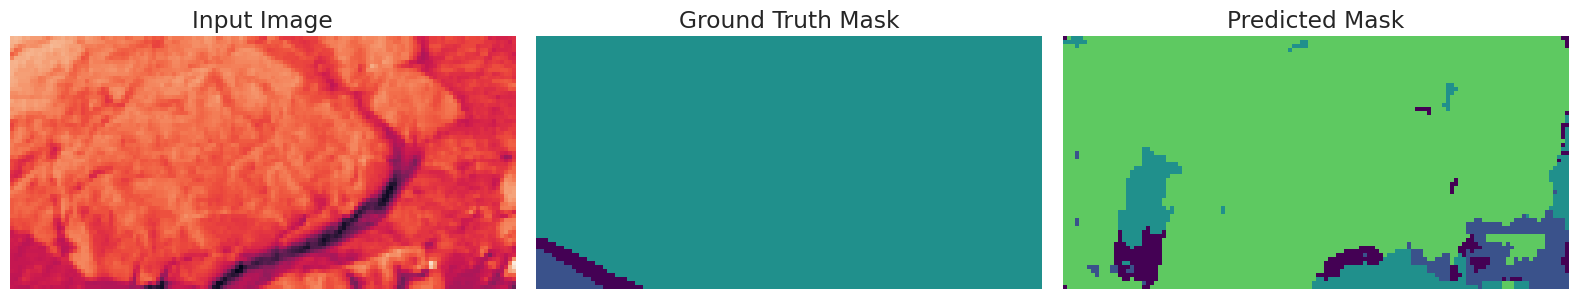

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.8785 - loss: 0.3203 - mean_iou: 0.5739 - val_accuracy: 0.6058 - val_loss: 1.1136 - val_mean_iou: 0.3233
Epoch 92/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.8731 - loss: 0.3333 - mean_iou: 0.5686 - val_accuracy: 0.5647 - val_loss: 1.2274 - val_mean_iou: 0.2891
Epoch 93/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.8769 - loss: 0.3255 - mean_iou: 0.5701 - val_accuracy: 0.6102 - val_loss: 1.1012 - val_mean_iou: 0.3177
Epoch 94/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.8754 - loss: 0.3255 - mean_iou: 0.5814 - val_accuracy: 0.6552 - val_loss: 0.8805 - val_mean_iou: 0.3583
Epoch 95/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8752 - loss: 0.3299 - mean_iou: 0.5788 - val_accuracy: 0.6923 - val_loss: 0.9402 - val_mean_iou: 0.3784
Epoch 96/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8903 - loss: 0.2938 - mean_iou: 0.5781

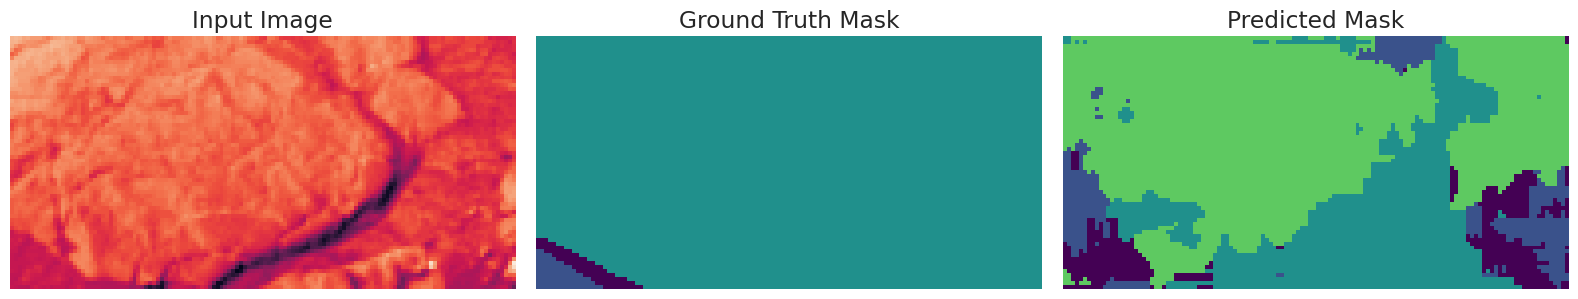

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.8904 - loss: 0.2934 - mean_iou: 0.5784 - val_accuracy: 0.7124 - val_loss: 0.7827 - val_mean_iou: 0.4233
Epoch 97/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8859 - loss: 0.3006 - mean_iou: 0.5884 - val_accuracy: 0.5888 - val_loss: 1.2760 - val_mean_iou: 0.3110
Epoch 98/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8843 - loss: 0.3068 - mean_iou: 0.5929 - val_accuracy: 0.6158 - val_loss: 1.1663 - val_mean_iou: 0.3277
Epoch 99/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8899 - loss: 0.2933 - mean_iou: 0.5878 - val_accuracy: 0.5903 - val_loss: 1.0898 - val_mean_iou: 0.3118
Epoch 100/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8644 - loss: 0.3584 - mean_iou: 0.5610 - val_accuracy: 0.5536 - val_loss: 1.4132 - val_mean_iou: 0.2821
Epoch 101/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8857 - loss: 0.3006 - mean_iou: 0.5862

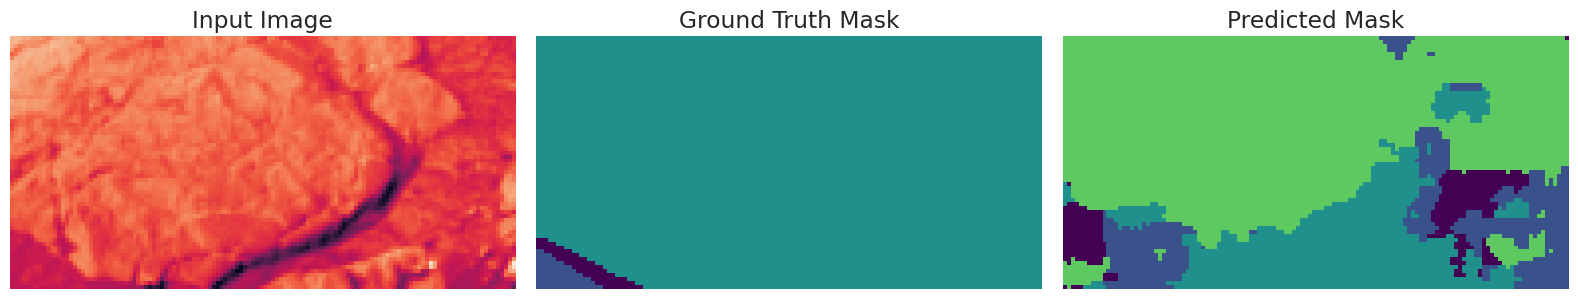

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.8860 - loss: 0.3000 - mean_iou: 0.5866 - val_accuracy: 0.5790 - val_loss: 1.1994 - val_mean_iou: 0.2955
Epoch 102/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.8793 - loss: 0.3180 - mean_iou: 0.5739 - val_accuracy: 0.6633 - val_loss: 0.9681 - val_mean_iou: 0.3493
Epoch 103/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8844 - loss: 0.3061 - mean_iou: 0.5896 - val_accuracy: 0.5798 - val_loss: 1.1952 - val_mean_iou: 0.2747
Epoch 104/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.8926 - loss: 0.2868 - mean_iou: 0.5899 - val_accuracy: 0.6490 - val_loss: 1.1083 - val_mean_iou: 0.3599
Epoch 105/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8911 - loss: 0.2879 - mean_iou: 0.5906 - val_accuracy: 0.4171 - val_loss: 2.4719 - val_mean_iou: 0.1730
Epoch 106/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8944 - loss: 0.2802 - mean_iou: 0.5981

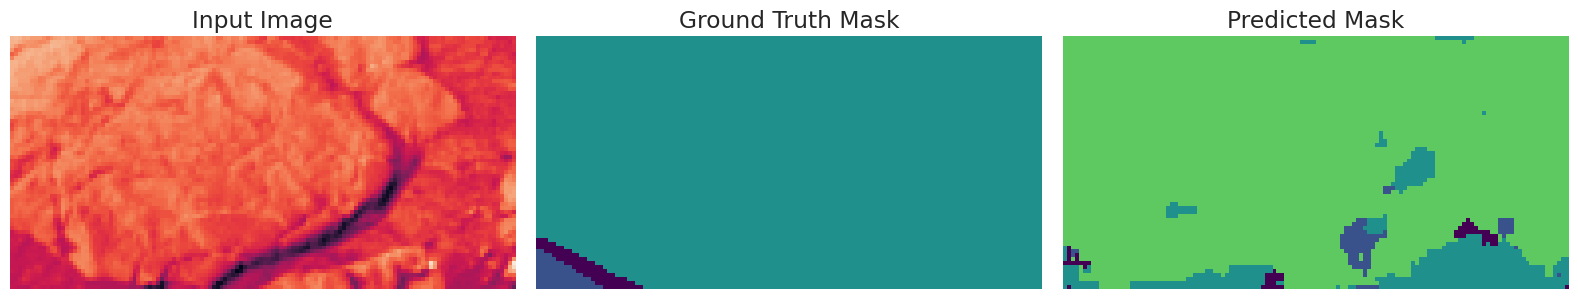

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.8948 - loss: 0.2792 - mean_iou: 0.5986 - val_accuracy: 0.5315 - val_loss: 1.6479 - val_mean_iou: 0.2586
Epoch 107/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9008 - loss: 0.2657 - mean_iou: 0.6217 - val_accuracy: 0.4534 - val_loss: 2.3632 - val_mean_iou: 0.2000
Epoch 108/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8845 - loss: 0.3058 - mean_iou: 0.5974 - val_accuracy: 0.4786 - val_loss: 1.9705 - val_mean_iou: 0.2100
Epoch 109/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9042 - loss: 0.2563 - mean_iou: 0.6142 - val_accuracy: 0.4633 - val_loss: 2.1605 - val_mean_iou: 0.2063
Epoch 110/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9117 - loss: 0.2381 - mean_iou: 0.6209 - val_accuracy: 0.4492 - val_loss: 2.1496 - val_mean_iou: 0.1984
Epoch 111/1000
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9143 - loss: 0.2325 - mean_iou: 0.6254

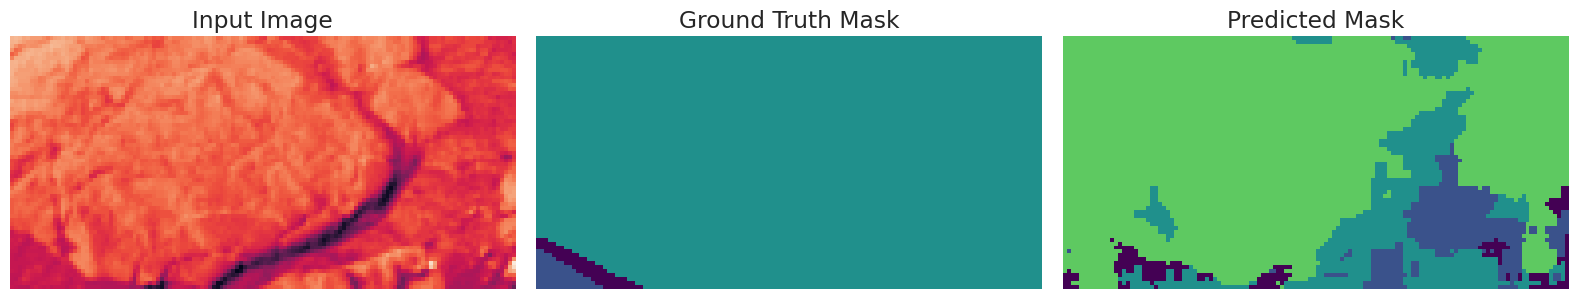

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.9143 - loss: 0.2324 - mean_iou: 0.6254 - val_accuracy: 0.6234 - val_loss: 1.2441 - val_mean_iou: 0.3447
Epoch 112/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9061 - loss: 0.2505 - mean_iou: 0.6237 - val_accuracy: 0.4369 - val_loss: 2.4606 - val_mean_iou: 0.1841
Final validation Mean Intersection Over Union: 48.09%


In [19]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

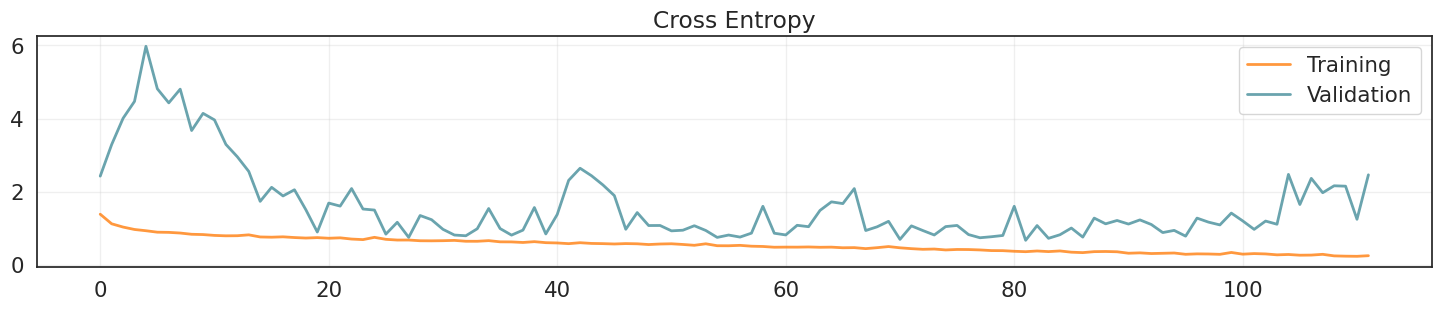

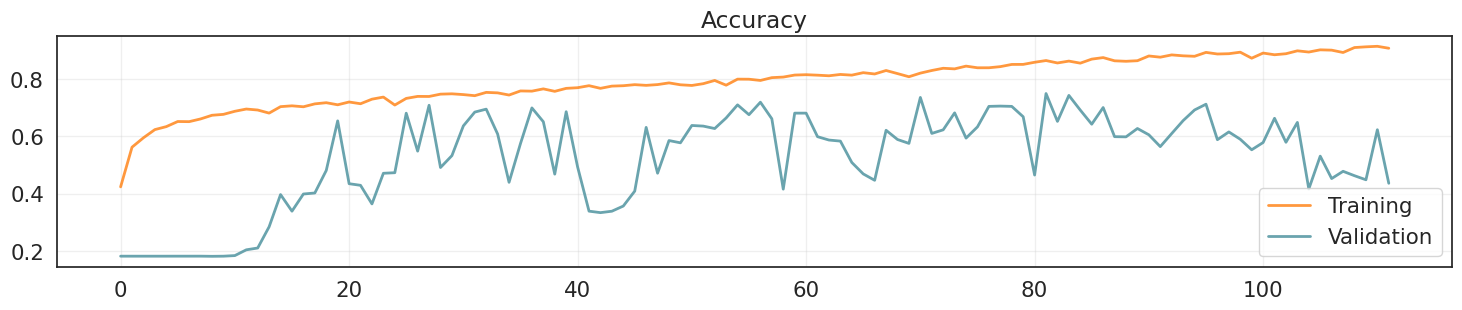

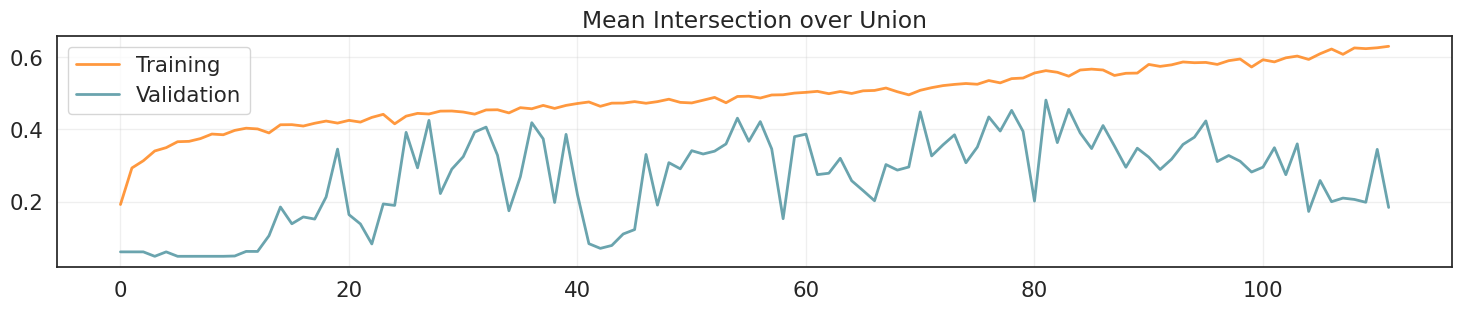

In [20]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()